# Simulating the Golenetskii correlation with popsynth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler

/Users/fran/.virtualenvs/grb/lib/python3.8/site-packages/popsynth/distribution.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as progress_bar


In [2]:
%env DISPLAY=:0.0
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=16
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1 

env: DISPLAY=:0.0
env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=16
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


## GRB population

In [22]:
# redshift distribution
r0_true = 1. #1/20.
rise_true = 1.
decay_true = 4.0
peak_true = 1.5
r_max = 7.0


pop_gen = popsynth.populations.SFRPopulation(
    r0=r0_true,
    rise=rise_true,
    decay=decay_true,
    peak=peak_true,
    r_max=r_max,
)

## Auxiliary samplers

In [23]:
from zusammen.synthetic_populations.aux_samplers import DurationSampler, EpeakObsSampler, LumSampler

In [24]:
t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.25

log_ep = LogNormalAuxSampler(name="log_ep", observed=False)
log_ep.mu=300
log_ep.tau=0.4

log_nrest = LogNormalAuxSampler(name="log_nrest", observed=False)
log_nrest.mu = 1e52
log_nrest.tau = 0.1

gamma = TruncatedNormalAuxSampler(name="gamma", observed=False)
gamma.mu = 1.5
gamma.tau = 0.5
gamma.lower = 1.0
gamma.upper = 2.0

duration = DurationSampler()
obs_lum = LumSampler()
log_ep_obs = EpeakObsSampler()
duration.set_secondary_sampler(t90)
obs_lum.set_secondary_sampler(log_ep)
obs_lum.set_secondary_sampler(log_nrest)
obs_lum.set_secondary_sampler(gamma)
log_ep_obs.set_secondary_sampler(log_ep)

In [25]:
pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(obs_lum)
pop_gen.add_observed_quantity(log_ep_obs)

registering auxilary sampler: duration
registering derived luminosity sampler: obs_lum
registering auxilary sampler: log_ep_obs


## Survey

In [7]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2, flux_sigma=0.)

The volume integral is 38.111186



Expecting 32 total objects
Sampling: obs_lum
obs_lum is sampling its secondary quantities
Sampling: log_ep
Sampling: log_nrest
Sampling: gamma
Getting luminosity from derived sampler
Sampling: duration
duration is sampling its secondary quantities
Sampling: log_t90
Sampling: log_ep_obs
log_ep_obs is sampling its secondary quantities
Applying soft boundary



No Selection! Added back all objects
NO HIDDEN OBJECTS
Deteced 32 objects or to a distance of 3.08


Text(0, 0.5, '$L$ (erg/s)')

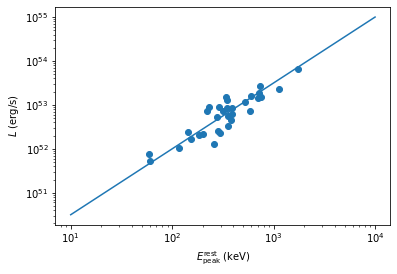

In [26]:
fig, ax = plt.subplots()
Egrid = 10**np.linspace(1, 4)

ax.scatter(10**population.log_ep, population.luminosities)
#ax.scatter(10**population.log_ep, population.obs_lum)
ax.plot(Egrid, 1e52 * np.power(Egrid/100, 1.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{rest}$ (keV)')
ax.set_ylabel('$L$ (erg/s)')

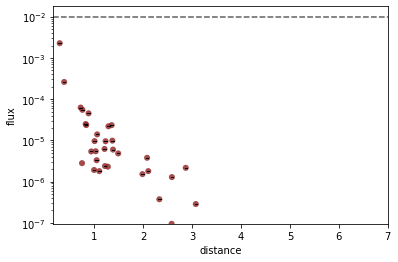

In [27]:
population.display_fluxes();

In [30]:
population.log_ep_obs.min()

1.2261687452945422

Text(0, 0.5, '$F_E$ (erg $\\mathrm{s}^{-1}$ $\\mathrm{cm}^{-2}$)')

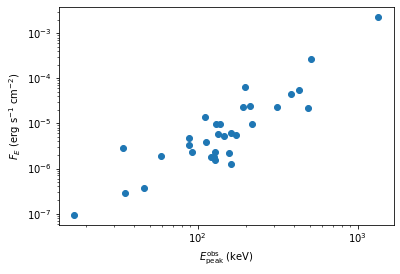

In [31]:
fig, ax = plt.subplots()
ax.scatter(10**population.log_ep_obs, population.latent_fluxes)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{obs}$ (keV)')
ax.set_ylabel('$F_E$ (erg $\mathrm{s}^{-1}$ $\mathrm{cm}^{-2}$)')

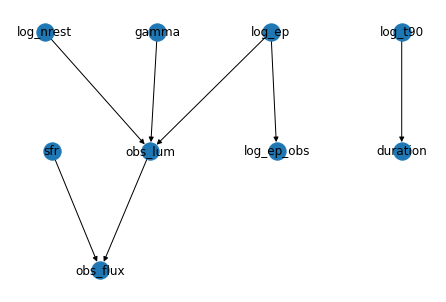

In [32]:
pos=nx.drawing.nx_agraph.graphviz_layout(pop_gen.graph, prog='dot')

nx.draw(pop_gen.graph, with_labels=True,pos=pos)